# Import all librairies

In [116]:
import requests
import numpy as np
import time 
import tensorflow as tf
import pdb
import sys
import urllib, json
from tensorflow import keras
from tensorflow.keras import layers
import datetime
from datetime import date
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from keras import layers, initializers
import os
import gradio as gr

# define all important parameters 

In [4]:
api_key = 'RGAPI-56114a65-e4c2-48cf-99c7-01bbfcd70f06'
url_all_queue_Id = 'https://static.developer.riotgames.com/docs/lol/queues.json'
queue_Id_solo_duo = 420
url = 'http://ddragon.leagueoflegends.com/cdn/12.23.1/data/en_US/champion.json'
response = urllib.request.urlopen(url)
all_champions = json.loads(response.read())
number_of_champions = len(all_champions['data'])
champ_Id = {}
for i, champions  in enumerate(all_champions['data'].keys()):
    champ_Id[str(champions).lower()] = i

# define all functions used

In [120]:

def get_puuid_by_summoner_name(summoner_name, key = api_key):
    request_summoner = 'https://euw1.api.riotgames.com/lol/summoner/v4/summoners/by-name/' + summoner_name.replace(' ', '%20') + '?api_key=' + key

    while True:
        summoner_info_response = requests.get(request_summoner)
        if summoner_info_response.status_code == 200: #means that the request has been answered without issues
            break
        if summoner_info_response.status_code == 429:
            print('sleeping because the max number of request has been reached')
            time.sleep(50)
        else:
            print(f'error during a request in the function get_puuid, error code = {summoner_info_response.status_code}')
            a == 0 #made on purpose to stop the code to avoid endless loop
    
    summoner_info = summoner_info_response.json()
    puuid = summoner_info['puuid']
    return puuid

def get_summoner_Id_by_summoner_name(summoner_name, key = api_key):
    request_summoner = 'https://euw1.api.riotgames.com/lol/summoner/v4/summoners/by-name/' + summoner_name.replace(' ', '%') + '?api_key=' + key
    while True:
        summoner_info_response = requests.get(request_summoner)

        if summoner_info_response.status_code == 200: #means that the request has been answered without issues
            break
        if summoner_info_response.status_code == 429:
            print('sleeping because the max number of request has been reached')
            time.sleep(50)
        else:
            print(f'error during a request in the function get_summoner_Id_by_summoner_name, error code = {summoner_info_response.status_code}')
            a == 0 #made on purpose to stop the code to avoid endless loop

    summoner_info = summoner_info_response.json()
    summoner_Id = summoner_info['id']
    return summoner_Id


def get_puuid_by_summoner_Id(summoner_Id, key = api_key, display_informations = False):
    
    request_puuid = 'https://euw1.api.riotgames.com/lol/summoner/v4/summoners/' + summoner_Id + '?api_key=' + key
    while True:
        summoner_info_response = requests.get(request_puuid)

        if summoner_info_response.status_code == 200: #means that the request has been answered without issues
            break
        elif summoner_info_response.status_code == 429:
            if display_informations: 
                print('sleeping because the max number of request has been reached')
            time.sleep(50)
        elif summoner_info_response.status_code == 503:
            print('sleeping because the serveur has an issue')
            time.sleep(50)
        else:
            print(f'error during a request in the function get_puuid, error code = {summoner_info_response.status_code}')
            a == 0 #made on purpose to stop the code to avoid endless loop
    
    summoner_info = summoner_info_response.json()
    puuid = summoner_info['puuid']
    return puuid


def get_matches_id_list_by_puuid(puuid, count = 20, key = api_key, display_informations = False):
    request_game = 'https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/' + puuid + '/ids?queue=' + str(queue_Id_solo_duo) + '&start=0&count=' + str(count) + '&api_key=' + key
    
    while True:
        game_info_response = requests.get(request_game)

        if game_info_response.status_code == 200: #means that the request has been answered without issues
            break
        elif game_info_response.status_code == 429:
            if display_informations: 
                print('sleeping because the max number of request has been reached')
            time.sleep(50)
        elif game_info_response.status_code == 503:
            print('sleeping because the serveur has an issue')
            time.sleep(50)
        else:
            print(f'error during a request in the function get_matches_id_list_by_puuid, error code = {game_info_response.status_code}')
            a == 0 #made on purpose to stop the code to avoid endless loop
    game_info = game_info_response.json()
    return game_info

def x_squared(x):
    return x**2

def times_1_5(x):
    return x**1.5

def identity(x):
    return x

def get_rank_info_by_match_id(matchId, function_calcul_relative_rank = identity, key = api_key, display_informations = False):
    request_game = 'https://europe.api.riotgames.com/lol/match/v5/matches/' + matchId + '?api_key=' + key
    while True:
        game_info_response = requests.get(request_game)

        if game_info_response.status_code == 200: #means that the request has been answered without issues
            break
        elif game_info_response.status_code == 429:
            if display_informations: 
                print('sleeping because the max number of request has been reached') 
            time.sleep(50)
        elif game_info_response.status_code == 503:
            print('sleeping because the serveur has an issue')
            time.sleep(50)
        else:
            print(f'error during a request in the function get_rank_info_by_match_id, error code = {game_info_response.status_code}')
            a == 0 #made on purpose to stop the code to avoid endless loop
            
    game_info = game_info_response.json()

    all_summoner_id = [game_info['info']['participants'][i]['summonerId'] for i in range(10)]
    game_infos = {}
    game_infos['game_creation'] = game_info['info']['gameCreation']
    all_infos = []
    for i in range(10):
        request_rank = 'https://euw1.api.riotgames.com/lol/league/v4/entries/by-summoner/' + all_summoner_id[i] + '?api_key=' + key
        while True:
            rank_info_res = requests.get(request_rank)

            if rank_info_res.status_code == 200: #means that the request has been answered without issues
                break
            elif rank_info_res.status_code == 429:
                if display_informations:
                    print('sleeping because the max number of request has been reached')
                time.sleep(50)
            elif rank_info_res.status_code == 503:
                print('sleeping because the serveur has an issue')
                time.sleep(50)
            else:
                print(f'error during a request in the function get_rank_info_by_match_id, error code = {rank_info_res.status_code}')
                a == 0 #made on purpose to stop the code to avoid endless loop

        rank_info = rank_info_res.json()
        arg_rank_solo_duo = 'rien'
        if len(rank_info) == 0:
            if display_informations:
                print('invalid game, one of the player is unranked in solo duo')
            return {}
        for j in range(len(rank_info)):

            if (rank_info[j]['queueType'] == 'RANKED_SOLO_5x5'):
                arg_rank_solo_duo = j
                break
        if arg_rank_solo_duo == 'rien':
            if display_informations:
                print('invalid game, one of the player is unranked in solo duo')
            return {}
        win = game_info['info']['participants'][i]['win']
        tier = rank_info[arg_rank_solo_duo]['tier']
        rank = rank_info[arg_rank_solo_duo]['rank']
        leaguePoints = rank_info[arg_rank_solo_duo]['leaguePoints']
        summoner_puuid = game_info['info']['participants'][i]['puuid']
        position = game_info['info']['participants'][i]['teamPosition']
        relative_LP = normalization_rank(rank_info[arg_rank_solo_duo], function_calcul_relative_rank)
        relative_side = game_info['info']['participants'][i]['teamId']

        champion_name = game_info['info']['participants'][i]['championName'].lower()

        championId = champ_Id[champion_name]
        if relative_side == 100:
             side = 'blue'
        if relative_side == 200:
             side = 'red'
        dico = {'tier': tier, 'div': rank, 'leaguePoints': leaguePoints, 'summoner_puuid': summoner_puuid, 'position' : position , 'champion_name' : champion_name}
        dico['side'] = side
        dico['relative_LP'] = relative_LP
        dico['relative side'] = relative_side
        dico['win'] = win
        dico['championId'] = championId
        all_infos.append(dico)
    game_infos['info'] = all_infos
    return game_infos

def get_moyenne_of_a_match(match_info):
    if match_info == []:
        return {}
    moyenne_LP_win = np.mean(np.array([rank['leaguePoints'] for rank in match_info if rank['win'] == True]))
    moyenne_LP_lose = np.mean(np.array([rank['leaguePoints'] for rank in match_info if rank['win'] == False]))
    dico = {'moyenne_LP_win' : moyenne_LP_win, 'moyenne_LP_lose' : moyenne_LP_lose}
    return dico

def get_moyenne_of_matches(list_matches_Id):
    nb_matches = len(list_matches_Id)
    all_moyennes = []
    for i in range(nb_matches):
        rank_info = get_rank_info_by_match_id(list_matches_Id[i])
        if rank_info == []:
            pass
        moyennes = get_moyenne_of_a_match(rank_info)
        if moyennes != {}:
            all_moyennes.append(moyennes)
    return all_moyennes

def predict_win(all_moyennes):
    nb_total_of_games = len(all_moyennes)
    nb_times_most_LP_win = 0
    nb_times_less_LP_win = 0
    for i in range(nb_total_of_games):
        if all_moyennes[i]['moyenne_LP_win'] > all_moyennes[i]['moyenne_LP_lose']:
            nb_times_most_LP_win += 1
        else:
            nb_times_less_LP_win += 1
    pourcentage_of_times_max_LP_win = nb_times_most_LP_win / nb_total_of_games
    print(f'nb_total_of_games = {nb_total_of_games}')
    print(f'nb_times_most_LP_win = {nb_times_most_LP_win}')
    print(f'nb_times_less_LP_win = {nb_times_less_LP_win}')
    print(f'pourcentage_of_times_max_LP_win = {pourcentage_of_times_max_LP_win}')
    
def get_all_infos_for_several_games(all_matches, function_calcul_relative_rank):
    all_infos = []
    nb_games = len(all_matches)
    for i in range(nb_games):
        info_game = get_rank_info_by_match_id(all_matches[i], function_calcul_relative_rank)
        if info_game != []:
            all_infos.append(info_game)
    return all_infos

def normalization_division(division, above_diamond):
    if above_diamond == True:
        return 0
    if division == 'I':
        mult = 3
    if division == 'II':
        mult = 2
    if division == 'III':
        mult = 1
    if division == 'IV':
        mult = 0  
        
    return mult

def normalization_rank(info, function = identity):
    mult_rank = 0
    tier = info['tier']
    division = info['rank']
    LP = info['leaguePoints']
    if tier == 'IRON':
        mult_rank = 0
        mult_div = normalization_division(division, False)
    if tier == 'BRONZE':
        mult_rank = 1
        mult_div = normalization_division(division, False)
    if tier == 'SILVER':
        mult_rank = 2
        mult_div = normalization_division(division, False)
    if tier == 'GOLD':
        mult_rank = 3    
        mult_div = normalization_division(division, False)
    if tier == 'PLATINUM':
        mult_rank = 4
        mult_div = normalization_division(division, False)
    if tier == 'DIAMOND':
        mult_rank = 5
        mult_div = normalization_division(division, False)
    if tier == 'MASTER' or tier == 'CHALLENGER' or tier == 'GRANDMASTER' :
        mult_rank = 6
        mult_div = normalization_division(division, True)
    rank = mult_rank * 400 + mult_div * 100 + LP
    rank = function(rank)/ function(4200)

    return rank


def extract_caract(info, nb_champions = number_of_champions):
    if info == {}:
        return []
    res = []

    for side in (['blue', 'red']):
        result = []
        result += [info['info'][i]['relative_LP'] for i in range(10) if info['info'][i]['side'] == side and info['info'][i]['position'] == 'TOP']
        result += [info['info'][i]['relative_LP'] for i in range(10) if info['info'][i]['side'] == side and info['info'][i]['position'] == 'JUNGLE']
        result += [info['info'][i]['relative_LP'] for i in range(10) if info['info'][i]['side'] == side and info['info'][i]['position'] == 'MIDDLE']
        result += [info['info'][i]['relative_LP'] for i in range(10) if info['info'][i]['side'] == side and info['info'][i]['position'] == 'BOTTOM']
        result += [info['info'][i]['relative_LP'] for i in range(10) if info['info'][i]['side'] == side and info['info'][i]['position'] == 'UTILITY']
        
        tab = nb_champions * [0]
        for i in range(10):
            if info['info'][i]['side'] == side:
                tab[info['info'][i]['championId']] = 1 

        result += tab
        res.append(result)

    if info['info'][0]['side'] == 'blue':
        if info['info'][0]['win'] == True:
            win = [0]
        else:
            win = [1]
    else:
        if info['info'][0]['win'] == True:
            win = [1]
        else:
            win = [0]

    if np.asarray(res).shape != (2, number_of_champions + 5):
        return []

    return res, win

def get_summoners_Id_from_a_league(league = 'MASTER', key = api_key, display_informations = False):
    request_players = 'https://euw1.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/' + league + '/I?page=1&api_key=' + key
    while True:
        players_info_response = requests.get(request_players)

        if players_info_response.status_code == 200: #means that the request has been answered without issues
            break
        elif players_info_response.status_code == 429:
            if display_informations:
                print('sleeping because the max number of request has been reached')
            time.sleep(50)
        elif players_info_response.status_code == 503:
            print('sleeping because the serveur has an issue')
            time.sleep(50)
        else:
            print(f'error during a request in the function get_players_from_a_league, error code = {players_info_response.status_code}')
            a == 0 #made on purpose to stop the code to avoid endless loop
            
    players_info = players_info_response.json()
    nb_players = len(players_info)

    summoner_Ids = np.array([players_info[i]['summonerId'] for i in range(nb_players)])

    return summoner_Ids
    
def creation_of_the_database(nb_games, league = 'MASTER', max_time = 2, display_informations = False): #max_time correspond to weeks
    nb_max_of_games_per_summoner = 100
    max_time_between_now_and_game = max_time * 1000 * 60 * 60 * 24 * 7 
    summoners_Id = get_summoners_Id_from_a_league(league = league)
    nb_game = 0
    num_summoner = 0
    data = {'x': [], 'y' : []}
    with tqdm(total = nb_games) as pbar:
        while nb_game < nb_games:
            if num_summoner >= len(summoners_Id):
                print('not enough summoners to get that much games')
                break
            summoner_Id = summoners_Id[num_summoner]
            puuid = get_puuid_by_summoner_Id(summoner_Id)
            match_list = get_matches_id_list_by_puuid(puuid, count = nb_max_of_games_per_summoner)
            for match_Id in match_list:
                info_match = get_rank_info_by_match_id(match_Id)
                if info_match == {}:
                    continue

                time_now = 1000 * datetime.datetime.now().timestamp() #number of millisecond since the first of january 1970 at 9am
                diff = time_now - info_match['game_creation'] 
                if diff > max_time_between_now_and_game:
                    if display_informations:
                        print('the game is too old')
                    break
                data['x'].append(extract_caract(info_match)[0])
                data['y'].append(extract_caract(info_match)[1])
                nb_game += 1
                pbar.update(1)
                if nb_game >= nb_games:
                    break
            num_summoner += 1
    pbar.close()
    data['x'] = data['x']
    data['y'] = data['y']
    return data


# creation of the database

In [6]:
number_of_games = 3
data = creation_of_the_database(number_of_games, league = 'SILVER', max_time = 1, display_informations = False)

with open(f'data_{number_of_games}.json', 'w') as fichier:
    json.dump(data, fichier)


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


# all functions used to define the different models

In [132]:
def suffle_the_data(database, seed):
    
    def my_function(): #is used to randomize in the same way several lists
        return seed
    
    database_x = database['x']
    database_y = database['y']
    
    random.shuffle(database_x, my_function)
    random.shuffle(database_y, my_function)
    
    return database_x, database_y

def build_trivial_model(database_train_x, database_train_y):
    
    input_shape_model = np.asarray(database_train_x[0]).shape
    
    constant = np.mean(np.asarray(database_train_y))
    
    model_trivial = tf.keras.Sequential()
    model_trivial.add(tf.keras.layers.Flatten(input_shape = input_shape_model))
    model_trivial.add(tf.keras.layers.Dense(0, activation = None))
    model_trivial.add(tf.keras.layers.Dense(1, activation = None,\
    bias_initializer = initializers.Constant(constant)))  

    model_trivial.summary()    

    model_trivial.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    )

    return model_trivial


def build_linear_model(database_train_x, seed = 0.4, learning_rate = 0.01):
    
    input_shape_model = np.asarray(database_train_x[0]).shape
    #initializer = tf.keras.initializers.GlorotUniform(seed)
    initializer = tf.keras.initializers.GlorotUniform()
    
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape = input_shape_model))
    linear_model.add(tf.keras.layers.Dense(1, activation = None, kernel_initializer = initializer))
    
    linear_model.summary()
    
    linear_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    )
    
    return linear_model

def build_simple_model(database_train_x, seed = 0.4, learning_rate = 0.01):
    
    input_shape_model = np.asarray(database_train_x[0]).shape
    
    #initializer = tf.keras.initializers.GlorotUniform(seed)
    initializer = tf.keras.initializers.GlorotUniform()
    
    simple_model = tf.keras.Sequential()
    simple_model.add(tf.keras.layers.Flatten(input_shape = input_shape_model))
    simple_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    
    simple_model.summary()
    
    simple_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    )
    
    return simple_model

def build_complex_model(database_train_x, number_of_hidden_neurons, seed = 0.4, learning_rate = 0.01):
    
    input_shape_model = np.asarray(database_train_x[0]).shape
    
    #initializer = tf.keras.initializers.GlorotUniform(seed)
    initializer = tf.keras.initializers.GlorotUniform()
    
    complex_model = tf.keras.Sequential()
    complex_model.add(tf.keras.layers.Flatten(input_shape = input_shape_model))
    complex_model.add(tf.keras.layers.Dense(number_of_hidden_neurons, activation = 'relu', kernel_initializer = initializer))
    complex_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    
    complex_model.summary()
    
    complex_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    )
    
    return complex_model

# calculate the differences between the several models

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 334)               0         
                                                                 
 dense_65 (Dense)            (None, 0)                 0         
                                                                 
 dense_66 (Dense)            (None, 1)                 1         
                                                                 
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


C:\Users\cleme\AppData\Local\Temp\ipykernel_18004\1401307145.py:9: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(database_x, my_function)
C:\Users\cleme\AppData\Local\Temp\ipykernel_18004\1401307145.py:10: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(database_y, my_function)


1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000
complexity = linear model, num_of initilisation = 0
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_42 (Flatten)        (None, 334)               0         
                                                                 
 dense_67 (Dense)            (None, 1)                 335       
                                                                 
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________
fit in progress
Epoch 1/5
1/1 [==============================] - 0s 229ms/step - loss: 0.4753 - binary_accuracy: 0.3750
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.3133 - binary_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2008 - bi

C:\Users\cleme\.conda\envs\riot_dev\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/5
1/1 [==============================] - 0s 347ms/step - loss: 0.7195 - binary_accuracy: 0.1250
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 0.6987 - binary_accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.6901 - binary_accuracy: 0.7500
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.6821 - binary_accuracy: 0.8750
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.6784 - binary_accuracy: 0.8750
evaluate in progress
1/1 [==============================] - 0s 88ms/step - loss: 0.7184 - binary_accuracy: 0.0000e+00
complexity = 2 H neurons, num_of initilisation = 0
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_45 (Flatten)        (None, 334)               0         
                                                                 
 dense_71 (Dense)            (No

[]

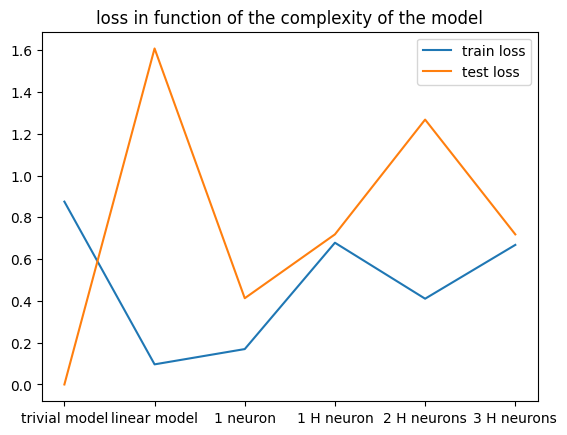

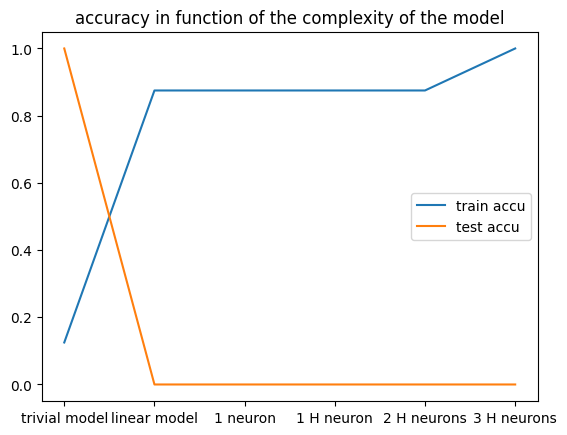

In [133]:
'''chargement of the data'''
name_of_the_data_file = 'data_3000.json'
with open(name_of_the_data_file) as mon_fichier: 
    data = json.load(mon_fichier)
    
#seed  = random.uniform(0.2,0.9)
seed = 0.4
database = suffle_the_data(data, seed)

'''some parameters for the database'''
data_x = database[0][:10]
data_y = database[1][:10]

nb_exemples = len(data_x)
pourcentage_test = 0.2
nb_exemples_test = int(nb_exemples * pourcentage_test)
nb_epochs = 5
batch = 64

''' separation of the datas'''
data_test_x = data_x[0: nb_exemples_test] 
data_test_y = data_y[0: nb_exemples_test] 

data_train_x = data_x[nb_exemples_test : ] 
data_train_y = data_y[nb_exemples_test : ] 

'''set up for the differents models
the trivial model correspond to the mean of the outputs of the training data
the linear model correspond to one perceptron without an activation function
the model with 1 neuron correspond to one perceptron without the function sigmoid as the activation function
the model X H neurons correspond to an hidden layer with X perceptrons with the activation RELU and one output perceptron
with the activation sigmoid
'''
complexity = ['trivial model', 'linear model', '1 neuron', '1 H neuron', '2 H neurons', '3 H neurons']
number_of_model = len(complexity) 
nb_initialisations = [1 for i in range(len(complexity))]

res_loss_train = []
res_loss_test = []
min_res_loss = [] #we take the initalisation that created the best loss, that is to say the minimal loss

res_accu_train = []
res_accu_test = []
min_res_accu = []

'''model trivial'''
model_trivial = build_trivial_model(data_train_x, data_train_y)

result_model_trivial = model_trivial.evaluate(data_train_x, data_train_y)

loss_train = model_trivial.evaluate(data_train_x, data_train_y)[0]
loss_test = model_trivial.evaluate(data_test_x, data_test_y)[0]

accu_train = model_trivial.evaluate(data_train_x, data_train_y)[1]
accu_test = model_trivial.evaluate(data_test_x, data_test_y)[1]

res_loss_train.append(loss_train)
res_loss_test.append(loss_test)

res_accu_train.append(accu_train)
res_accu_test.append(accu_test)

for i, complex in enumerate(complexity[1:]):
    
    res_loss_inter_train = []
    res_loss_inter_test = []
    res_accu_inter_train = []
    res_accu_inter_test = []
    for nb_initialisation in range(nb_initialisations[i+1]):
        
        initializer = tf.keras.initializers.GlorotUniform(nb_initialisation)
        
        print(f'complexity = {complex}, num_of initilisation = {nb_initialisation}')
        if i == 0:
            model = build_linear_model(data_train_x, seed = seed, learning_rate = 0.01)
            
        elif i == 1:
            model = build_simple_model(data_train_x, seed = seed, learning_rate = 0.01)
            
        else:
            model = build_complex_model(data_train_x, i - 1, seed = seed, learning_rate = 0.01)

        print('fit in progress')
        history = model.fit(
        data_train_x, data_train_y, epochs=nb_epochs, batch_size = batch,  verbose = 'auto'
        )       
        print('evaluate in progress')
      
        train_loss_curve = history.history['loss']
        train_accu_curve = history.history['binary_accuracy']

        res_loss_inter_train.append(train_loss_curve[-1])
        res_accu_inter_train.append(train_accu_curve[-1])
 
        test_model = model.evaluate(data_test_x, data_test_y)
        loss_test_model = test_model[0]
        accu_test_model = test_model[1]
        res_loss_inter_test.append(loss_test_model)
        res_accu_inter_test.append(accu_test_model)
              
    arg_min_loss = np.argmin(np.asarray(res_loss_inter_train))

    res_loss_train.append(res_loss_inter_train[arg_min_loss])
    res_loss_test.append(res_loss_inter_test[arg_min_loss])

    res_accu_train.append(res_accu_inter_train[arg_min_loss])   
    res_accu_test.append(res_accu_inter_test[arg_min_loss])    

'''plot of all the results'''
plt.figure()
plt.plot(complexity, res_loss_train, label = 'train loss')
plt.plot(complexity, res_loss_test, label = 'test loss')
plt.title('loss in function of the complexity of the model')
plt.legend()
plt.plot()

plt.figure()
plt.plot(complexity, res_accu_train, label = 'train accu')
plt.plot(complexity, res_accu_test, label = 'test accu')
plt.title('accuracy in function of the complexity of the model')
plt.legend()
plt.plot()

# train a specific model

In [127]:
'''chargement of the data'''
name_of_the_data_file = 'data_3000.json'
with open(name_of_the_data_file) as mon_fichier: 
    data = json.load(mon_fichier)
    
seed  = random.uniform(0.2,0.9)
database = suffle_the_data(data, seed)

data_x = database[0]
data_y = database[1]

'''parameters'''
nb_exemples = len(data_x)
pourcentage_test = 0.2
nb_exemples_test = int(nb_exemples * pourcentage_test)
nb_epochs = 500
batch = 64

''' separation of the datas'''
data_test_x = data_x[0: nb_exemples_test] 
data_test_y = data_y[0: nb_exemples_test] 

data_train_x = data_x[nb_exemples_test : ] 
data_train_y = data_y[nb_exemples_test : ] 

'''choose the model you want to train
trivial model correspond to the function build_trivial_model()
linear model correspond to the function build_linear_model()
1 neuron correspond to the function build_simple_model()
X H neuron correspond to the function build_complex(X) with X corresponding to the number of hidden neurons
'''
all_models = ['trivial model', 'linear model', '1 neuron', '1 H neuron', '2 H neurons', '3 H neurons']
model = simple_model(data_train_x, seed = 0.4, learning_rate = 0.01)

print('fit in progress')
history = model.fit(
            data_train_x, data_train_y, epochs=nb_epochs, batch_size = batch,  verbose = 2
)

'''save the model'''
model.save('default_model_simple')

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 334)               0         
                                                                 
 dense_64 (Dense)            (None, 1)                 335       
                                                                 
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


C:\Users\cleme\AppData\Local\Temp\ipykernel_18004\833271236.py:9: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(database_x, my_function)
C:\Users\cleme\AppData\Local\Temp\ipykernel_18004\833271236.py:10: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(database_y, my_function)


fit in progress
Epoch 1/500
38/38 - 0s - loss: 0.2519 - binary_accuracy: 0.5358 - 242ms/epoch - 6ms/step
Epoch 2/500
38/38 - 0s - loss: 0.2345 - binary_accuracy: 0.6117 - 27ms/epoch - 711us/step
Epoch 3/500
38/38 - 0s - loss: 0.2264 - binary_accuracy: 0.6379 - 28ms/epoch - 737us/step
Epoch 4/500
38/38 - 0s - loss: 0.2224 - binary_accuracy: 0.6450 - 27ms/epoch - 710us/step
Epoch 5/500
38/38 - 0s - loss: 0.2190 - binary_accuracy: 0.6525 - 28ms/epoch - 737us/step
Epoch 6/500
38/38 - 0s - loss: 0.2173 - binary_accuracy: 0.6579 - 29ms/epoch - 763us/step
Epoch 7/500
38/38 - 0s - loss: 0.2152 - binary_accuracy: 0.6617 - 43ms/epoch - 1ms/step
Epoch 8/500
38/38 - 0s - loss: 0.2142 - binary_accuracy: 0.6654 - 28ms/epoch - 724us/step
Epoch 9/500
38/38 - 0s - loss: 0.2130 - binary_accuracy: 0.6658 - 29ms/epoch - 763us/step
Epoch 10/500
38/38 - 0s - loss: 0.2122 - binary_accuracy: 0.6683 - 28ms/epoch - 737us/step
Epoch 11/500
38/38 - 0s - loss: 0.2112 - binary_accuracy: 0.6704 - 29ms/epoch - 763us/

38/38 - 0s - loss: 0.1939 - binary_accuracy: 0.7150 - 35ms/epoch - 932us/step
Epoch 92/500
38/38 - 0s - loss: 0.1946 - binary_accuracy: 0.7188 - 34ms/epoch - 905us/step
Epoch 93/500
38/38 - 0s - loss: 0.1940 - binary_accuracy: 0.7183 - 31ms/epoch - 828us/step
Epoch 94/500
38/38 - 0s - loss: 0.1947 - binary_accuracy: 0.7146 - 29ms/epoch - 756us/step
Epoch 95/500
38/38 - 0s - loss: 0.1936 - binary_accuracy: 0.7200 - 30ms/epoch - 779us/step
Epoch 96/500
38/38 - 0s - loss: 0.1927 - binary_accuracy: 0.7204 - 29ms/epoch - 750us/step
Epoch 97/500
38/38 - 0s - loss: 0.1938 - binary_accuracy: 0.7150 - 27ms/epoch - 724us/step
Epoch 98/500
38/38 - 0s - loss: 0.1930 - binary_accuracy: 0.7250 - 29ms/epoch - 768us/step
Epoch 99/500
38/38 - 0s - loss: 0.1933 - binary_accuracy: 0.7133 - 30ms/epoch - 784us/step
Epoch 100/500
38/38 - 0s - loss: 0.1931 - binary_accuracy: 0.7154 - 28ms/epoch - 744us/step
Epoch 101/500
38/38 - 0s - loss: 0.1933 - binary_accuracy: 0.7167 - 28ms/epoch - 748us/step
Epoch 102/

Epoch 181/500
38/38 - 0s - loss: 0.1872 - binary_accuracy: 0.7275 - 66ms/epoch - 2ms/step
Epoch 182/500
38/38 - 0s - loss: 0.1873 - binary_accuracy: 0.7312 - 55ms/epoch - 1ms/step
Epoch 183/500
38/38 - 0s - loss: 0.1879 - binary_accuracy: 0.7358 - 37ms/epoch - 986us/step
Epoch 184/500
38/38 - 0s - loss: 0.1875 - binary_accuracy: 0.7304 - 37ms/epoch - 980us/step
Epoch 185/500
38/38 - 0s - loss: 0.1873 - binary_accuracy: 0.7275 - 47ms/epoch - 1ms/step
Epoch 186/500
38/38 - 0s - loss: 0.1870 - binary_accuracy: 0.7312 - 44ms/epoch - 1ms/step
Epoch 187/500
38/38 - 0s - loss: 0.1869 - binary_accuracy: 0.7358 - 42ms/epoch - 1ms/step
Epoch 188/500
38/38 - 0s - loss: 0.1880 - binary_accuracy: 0.7296 - 39ms/epoch - 1ms/step
Epoch 189/500
38/38 - 0s - loss: 0.1868 - binary_accuracy: 0.7312 - 39ms/epoch - 1ms/step
Epoch 190/500
38/38 - 0s - loss: 0.1869 - binary_accuracy: 0.7312 - 53ms/epoch - 1ms/step
Epoch 191/500
38/38 - 0s - loss: 0.1875 - binary_accuracy: 0.7292 - 38ms/epoch - 1ms/step
Epoch 

Epoch 271/500
38/38 - 0s - loss: 0.1863 - binary_accuracy: 0.7300 - 26ms/epoch - 684us/step
Epoch 272/500
38/38 - 0s - loss: 0.1845 - binary_accuracy: 0.7367 - 26ms/epoch - 684us/step
Epoch 273/500
38/38 - 0s - loss: 0.1844 - binary_accuracy: 0.7421 - 26ms/epoch - 684us/step
Epoch 274/500
38/38 - 0s - loss: 0.1839 - binary_accuracy: 0.7375 - 26ms/epoch - 684us/step
Epoch 275/500
38/38 - 0s - loss: 0.1846 - binary_accuracy: 0.7346 - 26ms/epoch - 684us/step
Epoch 276/500
38/38 - 0s - loss: 0.1842 - binary_accuracy: 0.7371 - 27ms/epoch - 698us/step
Epoch 277/500
38/38 - 0s - loss: 0.1841 - binary_accuracy: 0.7425 - 26ms/epoch - 684us/step
Epoch 278/500
38/38 - 0s - loss: 0.1841 - binary_accuracy: 0.7350 - 27ms/epoch - 710us/step
Epoch 279/500
38/38 - 0s - loss: 0.1845 - binary_accuracy: 0.7408 - 28ms/epoch - 737us/step
Epoch 280/500
38/38 - 0s - loss: 0.1842 - binary_accuracy: 0.7437 - 26ms/epoch - 684us/step
Epoch 281/500
38/38 - 0s - loss: 0.1843 - binary_accuracy: 0.7387 - 27ms/epoch -

38/38 - 0s - loss: 0.1833 - binary_accuracy: 0.7387 - 26ms/epoch - 684us/step
Epoch 361/500
38/38 - 0s - loss: 0.1832 - binary_accuracy: 0.7462 - 26ms/epoch - 684us/step
Epoch 362/500
38/38 - 0s - loss: 0.1828 - binary_accuracy: 0.7467 - 26ms/epoch - 684us/step
Epoch 363/500
38/38 - 0s - loss: 0.1842 - binary_accuracy: 0.7387 - 26ms/epoch - 684us/step
Epoch 364/500
38/38 - 0s - loss: 0.1825 - binary_accuracy: 0.7496 - 25ms/epoch - 658us/step
Epoch 365/500
38/38 - 0s - loss: 0.1833 - binary_accuracy: 0.7421 - 26ms/epoch - 684us/step
Epoch 366/500
38/38 - 0s - loss: 0.1835 - binary_accuracy: 0.7446 - 27ms/epoch - 711us/step
Epoch 367/500
38/38 - 0s - loss: 0.1827 - binary_accuracy: 0.7479 - 26ms/epoch - 684us/step
Epoch 368/500
38/38 - 0s - loss: 0.1825 - binary_accuracy: 0.7429 - 26ms/epoch - 684us/step
Epoch 369/500
38/38 - 0s - loss: 0.1826 - binary_accuracy: 0.7475 - 29ms/epoch - 751us/step
Epoch 370/500
38/38 - 0s - loss: 0.1825 - binary_accuracy: 0.7437 - 27ms/epoch - 711us/step
Ep

Epoch 450/500
38/38 - 0s - loss: 0.1823 - binary_accuracy: 0.7487 - 47ms/epoch - 1ms/step
Epoch 451/500
38/38 - 0s - loss: 0.1819 - binary_accuracy: 0.7462 - 43ms/epoch - 1ms/step
Epoch 452/500
38/38 - 0s - loss: 0.1819 - binary_accuracy: 0.7483 - 33ms/epoch - 875us/step
Epoch 453/500
38/38 - 0s - loss: 0.1826 - binary_accuracy: 0.7496 - 29ms/epoch - 770us/step
Epoch 454/500
38/38 - 0s - loss: 0.1819 - binary_accuracy: 0.7487 - 28ms/epoch - 737us/step
Epoch 455/500
38/38 - 0s - loss: 0.1822 - binary_accuracy: 0.7450 - 28ms/epoch - 737us/step
Epoch 456/500
38/38 - 0s - loss: 0.1820 - binary_accuracy: 0.7450 - 31ms/epoch - 816us/step
Epoch 457/500
38/38 - 0s - loss: 0.1819 - binary_accuracy: 0.7517 - 29ms/epoch - 763us/step
Epoch 458/500
38/38 - 0s - loss: 0.1821 - binary_accuracy: 0.7496 - 30ms/epoch - 790us/step
Epoch 459/500
38/38 - 0s - loss: 0.1821 - binary_accuracy: 0.7508 - 33ms/epoch - 868us/step
Epoch 460/500
38/38 - 0s - loss: 0.1815 - binary_accuracy: 0.7483 - 32ms/epoch - 842

# test the model

In [135]:
model_loaded = keras.models.load_model('default_model_single_layer')
model_loaded.summary()
test_model = model_loaded.evaluate(data_test_x, data_test_y)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 334)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 335       
                                                                 
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 86ms/step - loss: 0.0684 - binary_accuracy: 1.0000


# functions to create a game and predict it's result

In [139]:

def define_player(tier, division, Leaguepoints, champion_name):
    info = {'tier' : tier, 'rank': division, 'leaguePoints': Leaguepoints}
    relative_LP = normalization_rank(info)
    if champion_name == 'wukong':
        champion_name = 'monkeyking'
    champ_id = champ_Id[champion_name]
    dic = {'relative_LP' : relative_LP, 'champ_id': champ_id, 'champion_name': champion_name}
    return dic


def creation_match(blue_team, red_team):
    res = []
    for team in ([blue_team, red_team]):
        result = []
        result += [team['top']['relative_LP']]
        result += [team['jungle']['relative_LP']]
        result += [team['mid']['relative_LP']]
        result += [team['bottom']['relative_LP']]
        result += [team['utility']['relative_LP']]
        
        tab = number_of_champions * [0]
        positions = ['top', 'jungle', 'mid', 'bottom','utility']
        for pos in positions:
            tab[team[pos]['champ_id']] = 1 

        result += tab
        res.append(result)
    return res

def predict_winner(game, model_to_use):
    model_to_use.summary()
    print(np.asarray(game).shape)
    result = model_to_use.predict([game])[0][0]
    winner = round(result)
    if winner == 1:
        equipe_winner = 'red'
    if winner == 0:
        equipe_winner = 'blue'
    text = f'the {equipe_winner} team will win: final proba = {result}'
    return text

def predict_winner_interface(tier_top_blue, div_top_blue, lp_top_blue, champ_top_blue, tier_jungle_blue, div_jungle_blue,
                             lp_jungle_blue, champ_jungle_blue, tier_mid_blue, div_mid_blue, lp_mid_blue, champ_mid_blue, 
                             tier_bottom_blue, div_bottom_blue, lp_bottom_blue, champ_bottom_blue, tier_utility_blue, 
                             div_utility_blue, lp_utility_blue, champ_utility_blue, tier_top_red, div_top_red, lp_top_red, 
                             champ_top_red, tier_jungle_red, div_jungle_red, lp_jungle_red, champ_jungle_red, tier_mid_red, 
                             div_mid_red, lp_mid_red, champ_mid_red, tier_bottom_red, div_bottom_red, lp_bottom_red, 
                             champ_bottom_red, tier_utility_red, div_utility_red, lp_utility_red, champ_utility_red         
                            ):
    all_champs = [champ_top_blue, champ_jungle_blue, champ_mid_blue, champ_bottom_blue, champ_utility_blue, champ_top_red,
                 champ_jungle_red, champ_mid_red, champ_bottom_red, champ_utility_red]
    for champ in all_champs:
      if all_champs.count(champ) > 1:
        sys.exit('error, a champ can only be choosen once')
            
    team_1 = {'top' : define_player(tier_top_blue, div_top_blue, lp_top_blue, champ_top_blue),
              'jungle' : define_player(tier_jungle_blue, div_jungle_blue, lp_jungle_blue, champ_jungle_blue),
          'mid' : define_player(tier_mid_blue, div_mid_blue, lp_mid_blue, champ_mid_blue), 
              'bottom' : define_player(tier_bottom_blue, div_bottom_blue, lp_bottom_blue, champ_bottom_blue),
          'utility' : define_player(tier_utility_blue, div_utility_blue, lp_utility_blue, champ_utility_blue)}

    team_2 = {'top' : define_player(tier_top_red, div_top_red, lp_top_red, champ_top_red),
              'jungle' : define_player(tier_jungle_red, div_jungle_red, lp_jungle_red, champ_jungle_red),
          'mid' : define_player(tier_mid_red, div_mid_red, lp_mid_red, champ_mid_red), 
              'bottom' : define_player(tier_bottom_red, div_bottom_red, lp_bottom_red, champ_bottom_red),
          'utility' : define_player(tier_utility_red, div_utility_red, lp_utility_red, champ_utility_red)}
    
    game = creation_match(team_1, team_2)
    result = model.predict([game])[0][0]
    winner = round(result)
    if winner == 1:
        equipe_winner = 'red'
    if winner == 0:
        equipe_winner = 'blue'
    text = f'the {equipe_winner} team will win: final proba = {result}'
    return text

# define the model to use

In [138]:
model_to_use = keras.models.load_model('default_model_single_layer')
model_to_use.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 334)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 335       
                                                                 
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


# create the interface to predict the result of a game

In [140]:
all_tiers = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER' , 'GRANDMASTER', 'CHALLENGER']  
all_division = ['IV', 'III', 'II', 'I']


demo = gr.Interface(
    fn=predict_winner_interface,
    title="winner of the game prediction",
    description="Predict wich team will win the game",
    allow_flagging="never",
    inputs=[
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier top blue side"),
        gr.inputs.Dropdown(choices= all_division, default="I", label="division top blue side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points top blue side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="jax", label="champion top blue side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier jungle blue side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="division jungle blue side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points jungle blue side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="elise", label="champion jungle blue side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier mid blue side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="division mid blue side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points mid blue side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="fizz", label="champion mid blue side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier bottom blue side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="division bottom blue side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points bottom blue side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="jhin", label="champion bottom blue side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier utility blue side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="division utility blue side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points utility blue side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="bard", label="champion utility blue side"),
        
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier top red side"),
        gr.inputs.Dropdown(choices= all_division ,default="I", label="division top red side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points top red side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="darius", label="champion top red side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier jungle red side"),
        gr.inputs.Dropdown(choices= all_division ,default="I", label="division jungle red side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points jungle red side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="hecarim", label="champion jungle red side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier mid red side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="division mid red side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points mid red side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="yasuo", label="champion mid red side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier bottom red side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="bottom utility red side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points bottom red side"),
        gr.inputs.Dropdown(choices= list(champ_Id.keys()), default="ashe", label="champion bottom red side"),
        
        gr.inputs.Dropdown(choices= all_tiers, default="GOLD", label="tier utility red side"),
        gr.inputs.Dropdown(choices= all_division , default="I", label="division utility red side"),
        gr.inputs.Slider(minimum=0,maximum=2000,default=50,step=1, label="League points utility red side"),
        gr.inputs.Dropdown(choices=list(champ_Id.keys()), default="alistar", label="champion utility red side"),

        ],
    outputs = 'text')
    #outputs=gr.Image(type="pil"))


demo.launch(share=True, show_error = True)

C:\Users\cleme\.conda\envs\riot_dev\lib\site-packages\gradio\inputs.py:217: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\cleme\.conda\envs\riot_dev\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\cleme\.conda\envs\riot_dev\lib\site-packages\gradio\inputs.py:89: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7882
Running on public URL: https://e41cdbc8-9e6c-42fd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 30ms/step
